In [ ]:
import matplotlib.pyplot as plt
from numba import jit, cuda 
import pandas as pd
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.decomposition import PCA
import umap.umap_ as umap
import Dataloader as dl

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

# Loads data and returns a list of sentences as specfies in Dataloader
sentences = dl.loaddata()

# Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("KennethEnevoldsen/dfm-sentence-encoder-large")
model = AutoModel.from_pretrained("KennethEnevoldsen/dfm-sentence-encoder-large")

# Tokenize sentences
encoded_input = tokenizer(
    sentences, padding=True, truncation=True, max_length=128, return_tensors="pt"
)

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input["attention_mask"])

sentence_embeddings = sentence_embeddings.detach().numpy()

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(sentence_embeddings)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(sentence_embeddings)

# Perform UMAP
reducer = umap.UMAP()
X_umap = reducer.fit_transform(sentence_embeddings)

In [33]:
tokenizer = AutoTokenizer.from_pretrained("KennethEnevoldsen/dfm-sentence-encoder-large")
model = AutoModel.from_pretrained("KennethEnevoldsen/dfm-sentence-encoder-large")

Some weights of the model checkpoint at KennethEnevoldsen/dfm-sentence-encoder-large were not used when initializing BertModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.transform.LayerNorm.bias', 'lm_head.transform.LayerNorm.weight', 'lm_head.transform.dense.bias', 'lm_head.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


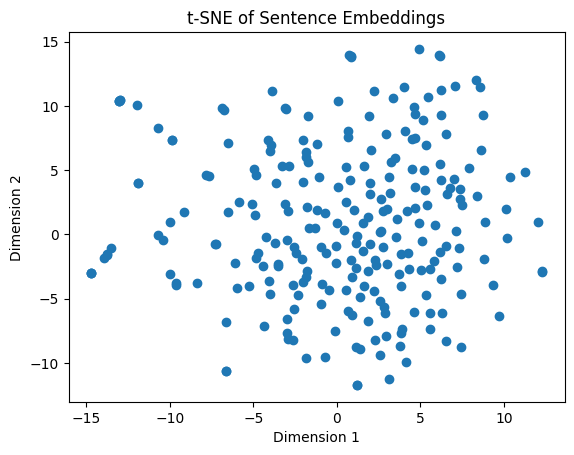

Text(0.5, 1.0, 'UMAP plot')

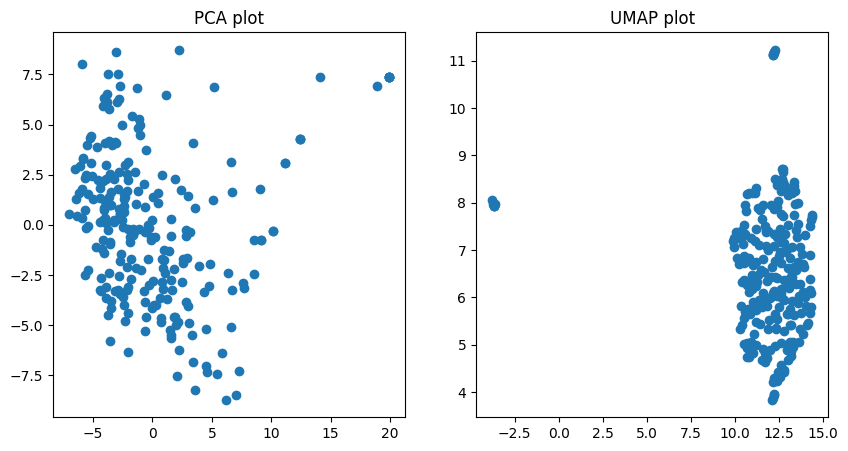

In [22]:
# Plot the results
plt.scatter(tsne_results[:,0], tsne_results[:,1])
plt.title('t-SNE of Sentence Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# Plot PCA
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA plot')

# Plot UMAP
plt.subplot(1, 2, 2)
plt.scatter(X_umap[:, 0], X_umap[:, 1])
plt.title('UMAP plot')

In [25]:
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
def answer_question(question, context):
    # Tokenize the input
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt', max_length=512, truncation=True)

    # Get the model's predictions
    outputs = model(**inputs)

    # Get the start and end scores
    start_scores, end_scores = outputs.start_logits, outputs.end_logits

    # Get the start and end positions
    start_idx = torch.argmax(start_scores)
    end_idx = torch.argmax(end_scores)

    # Get the answer
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][start_idx:end_idx+1]))

    return answer

context = 'en dødsforsikring er en forikring man får udbetalt hvis en person dør. det vil sige at jeg hedder rasmus og min partner heder emil'
question = "Hvad en dødsforsikring?"

print(answer_question(question, context))

er en forikring man far udbetalt hvis en person dør
